# Проект: телекоммуникации

**Описание проекта:**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

*Описание услуг:*

Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Цель проекта:** построить модель, которая будет предсказывать, разорвёт ли абонент договор.

**Описание данных:**

Данные состоят из нескольких файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

*Файл contract_new.csv:*
- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

*Файл personal_new.csv:*
- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

*Файл internet_new.csv:*
- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

*Файл phone_new.csv:*
- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

**План исследования:**

- загрузить и изучить данные
- провести предварительный исследовательский анализ и предобработку
- объединить таблицы в один датафрейм
- выполить исследовательский анализ и предобработку данных объединённого датафрейма
- выполнить подготовку данных для обучения модели
- обучить минимум две модели машинного обучения и выбрать лучшую модель
- сделать общий вывод и рекомендации заказчику

In [1]:
!pip install --upgrade scikit-learn -q
!pip install phik -q
!pip install shap -q

In [2]:
import re
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from scipy.stats import randint, uniform

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
import shap

from phik.report import plot_correlation_matrix

In [3]:
# задаем константы
DATA_LOAD = '2020-02-01'
RANDOM_STATE = 190525 
TEST_SIZE = 0.25

##  Загрузка данных

In [4]:
# чтение файлов всех таблиц, проверка общей информации
contract = pd.read_csv('/datasets/contract_new.csv')
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Прпусков нет, но надо преобразовать некоторые типы данных.

In [6]:
personal = pd.read_csv('/datasets/personal_new.csv')
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [7]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Пропусков нет.

In [8]:
internet = pd.read_csv('/datasets/internet_new.csv')
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропусков нет.

In [10]:
phone = pd.read_csv('/datasets/phone_new.csv')
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [11]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Прорусков нет.

*Данные загружены и соответствуют описанию.*

## Исследовательский анализ и предобработка данных

In [12]:
# приведем названия столбцов к единому стилю
# функция для преобразования названий столбцов
def to_snake_case(name):
    name = re.sub(r'([a-z])([A-Z])', r'\1_\2', name)
    name = re.sub(r'\s+', '_', name)
    return name.lower()

contract.columns = [to_snake_case(col) for col in contract.columns]
personal.columns = [to_snake_case(col) for col in personal.columns]
internet.columns = [to_snake_case(col) for col in internet.columns]
phone.columns = [to_snake_case(col) for col in phone.columns]

print(contract.columns,'\n\n', personal.columns, '\n\n', internet.columns, '\n\n', phone.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object') 

 Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object') 

 Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object') 

 Index(['customer_id', 'multiple_lines'], dtype='object')


In [13]:
# проверим клиентов, которые подписали договор в дату выгрузки базы
contract[contract['begin_date'] == '2020-02-01']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


У этих новых клиентов пустые значения в колонке total_charges, потому что видимо платеж снимается после прохождения месяца, а не сразу. Значит эти строки нужно будет заполнить нулями, так как действительно платеж они еще не совершали.

In [14]:
# преобразуем даты в формат datetime, колонку total_charges в float 

contract['begin_date'] = pd.to_datetime(contract['begin_date'])
contract['end_date'] = pd.to_datetime(contract['end_date'], errors='coerce')
contract['total_charges'] = contract['total_charges'].replace(' ', 0).astype(float)

contract.dtypes

customer_id                  object
begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges               float64
dtype: object

Далее будет создан новый признак "количество дней с момента начала договора", и наш целевой признак end_date преобразован в бинарный.

In [15]:
# проверим пропуский в данных и явные дубликаты
def check_missing_and_duplicates(data):
    print('Пропуски в таблице:')
    missing_values = data.isna().sum()
    print(missing_values[missing_values > 0])

    duplicates = data.duplicated().sum()
    print()
    if duplicates > 0:
        data.drop_duplicates(inplace=True)
        print(f'Явные дубликаты удалены! Их было {duplicates}.')
    else:
        print('Нет явных дубликатов!')

check_missing_and_duplicates(contract)

Пропуски в таблице:
end_date    5942
dtype: int64

Нет явных дубликатов!


Явных дубликатов нет, в end_date пропуски это из-за того, что все "No" были преобразованы в NaT (Not a Time), при преобразовании признака в datetime.

In [16]:
# проверим данные на неявные дубликаты по каждому столбцу с типом object
def clean_and_check_duplicates(df, columns):
    for column in columns:
        df[column] = df[column].str.strip().str.lower()
        print(f"Дубликаты в столбце '{column}':")
        print(df[column].value_counts())
        print()

clean_and_check_duplicates(contract, ['type', 'paperless_billing', 'payment_method'])

Дубликаты в столбце 'type':
month-to-month    3875
two year          1695
one year          1473
Name: type, dtype: int64

Дубликаты в столбце 'paperless_billing':
yes    4171
no     2872
Name: paperless_billing, dtype: int64

Дубликаты в столбце 'payment_method':
electronic check             2365
mailed check                 1612
bank transfer (automatic)    1544
credit card (automatic)      1522
Name: payment_method, dtype: int64



Неявных дубликатов не обнаружено.

In [17]:
# проверяем пропуски и явные и неявные дублткаты в таблице personal
check_missing_and_duplicates(personal)
print('')
clean_and_check_duplicates(personal, ['gender', 'partner', 'dependents'])

Пропуски в таблице:
Series([], dtype: int64)

Нет явных дубликатов!

Дубликаты в столбце 'gender':
male      3555
female    3488
Name: gender, dtype: int64

Дубликаты в столбце 'partner':
no     3641
yes    3402
Name: partner, dtype: int64

Дубликаты в столбце 'dependents':
no     4933
yes    2110
Name: dependents, dtype: int64



Всё отлично.

In [18]:
# проверяем пропуски и явные и неявные дублткаты в таблице internet
check_missing_and_duplicates(internet)
print('')
clean_and_check_duplicates(internet, ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'])

Пропуски в таблице:
Series([], dtype: int64)

Нет явных дубликатов!

Дубликаты в столбце 'internet_service':
fiber optic    3096
dsl            2421
Name: internet_service, dtype: int64

Дубликаты в столбце 'online_security':
no     3498
yes    2019
Name: online_security, dtype: int64

Дубликаты в столбце 'online_backup':
no     3088
yes    2429
Name: online_backup, dtype: int64

Дубликаты в столбце 'device_protection':
no     3095
yes    2422
Name: device_protection, dtype: int64

Дубликаты в столбце 'tech_support':
no     3473
yes    2044
Name: tech_support, dtype: int64

Дубликаты в столбце 'streaming_tv':
no     2810
yes    2707
Name: streaming_tv, dtype: int64

Дубликаты в столбце 'streaming_movies':
no     2785
yes    2732
Name: streaming_movies, dtype: int64



Всё хорошо.

In [19]:
# проверяем пропуски и явные и неявные дублткаты в таблице phone
check_missing_and_duplicates(phone)
print('')
clean_and_check_duplicates(phone, ['multiple_lines'])

Пропуски в таблице:
Series([], dtype: int64)

Нет явных дубликатов!

Дубликаты в столбце 'multiple_lines':
no     3390
yes    2971
Name: multiple_lines, dtype: int64



*Выполнено преобразование названий столбцов, некоторых типов данных, проверены пропуски и явные и неявные дубликаты.*

## Объединение данных

In [20]:
# объединяем 4 таблицы
data = (
        contract
        .merge(personal, on='customer_id', how='left')
        .merge(internet, on='customer_id', how='left')
        .merge(phone, on='customer_id', how='left')
    )

data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,month-to-month,yes,electronic check,29.85,31.04,female,0,yes,no,dsl,no,yes,no,no,no,no,NaN
1,5575-GNVDE,2017-04-01,NaT,one year,no,mailed check,56.95,2071.84,male,0,no,no,dsl,yes,no,yes,no,no,no,no
2,3668-QPYBK,2019-10-01,NaT,month-to-month,yes,mailed check,53.85,226.17,male,0,no,no,dsl,yes,yes,no,no,no,no,no
3,7795-CFOCW,2016-05-01,NaT,one year,no,bank transfer (automatic),42.30,1960.60,male,0,no,no,dsl,yes,no,yes,yes,no,no,NaN
4,9237-HQITU,2019-09-01,NaT,month-to-month,yes,electronic check,70.70,353.50,female,0,no,no,fiber optic,no,no,no,no,no,no,no


In [21]:
# смотрим на наличие пропусков, так как не все клиенты подключают и телефон и интернет
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

Проруски в колонке end_date я скоро заполню.

*В этом пункте я объединила таблицы.*

## Исследовательский анализ и предобработка данных объединённого датафрейма

Для тех клиентов, которые не пользуются либо телефоном либо интернетом поставим 'no internet service' и 'no phone service' вместо пропусков.

In [22]:
# ставим 'no internet service' и 'no phone service' вместо образовавшихся пропусков
data[['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']] = data[['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']].fillna('no internet service')
data['multiple_lines'] = data['multiple_lines'].fillna('no phone service')

data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,month-to-month,yes,electronic check,29.85,31.04,female,0,yes,no,dsl,no,yes,no,no,no,no,no phone service
1,5575-GNVDE,2017-04-01,NaT,one year,no,mailed check,56.95,2071.84,male,0,no,no,dsl,yes,no,yes,no,no,no,no
2,3668-QPYBK,2019-10-01,NaT,month-to-month,yes,mailed check,53.85,226.17,male,0,no,no,dsl,yes,yes,no,no,no,no,no
3,7795-CFOCW,2016-05-01,NaT,one year,no,bank transfer (automatic),42.30,1960.60,male,0,no,no,dsl,yes,no,yes,yes,no,no,no phone service
4,9237-HQITU,2019-09-01,NaT,month-to-month,yes,electronic check,70.70,353.50,female,0,no,no,fiber optic,no,no,no,no,no,no,no


In [23]:
# проверяем, чтобы пропуски были заполнены
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

Всё нормально, там где нужно, пропуски заполнены.

Теперь в столбцах, которые относятся к договору и клиенту, где бинарные признаки (yes/no), заменим их на 1 и 0.

In [24]:
# заменяем признаки и проверяем правильную замену
binary_columns = ['paperless_billing', 'partner', 'dependents'] 
data[binary_columns] = data[binary_columns].replace({'yes': 1, 'no': 0})

data.head(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,month-to-month,1,electronic check,29.85,31.04,female,0,1,0,dsl,no,yes,no,no,no,no,no phone service
1,5575-GNVDE,2017-04-01,NaT,one year,0,mailed check,56.95,2071.84,male,0,0,0,dsl,yes,no,yes,no,no,no,no
2,3668-QPYBK,2019-10-01,NaT,month-to-month,1,mailed check,53.85,226.17,male,0,0,0,dsl,yes,yes,no,no,no,no,no
3,7795-CFOCW,2016-05-01,NaT,one year,0,bank transfer (automatic),42.30,1960.60,male,0,0,0,dsl,yes,no,yes,yes,no,no,no phone service
4,9237-HQITU,2019-09-01,NaT,month-to-month,1,electronic check,70.70,353.50,female,0,0,0,fiber optic,no,no,no,no,no,no,no
5,9305-CDSKC,2019-03-01,NaT,month-to-month,1,electronic check,99.65,1150.96,female,0,0,0,fiber optic,no,no,yes,no,yes,yes,yes
6,1452-KIOVK,2018-04-01,NaT,month-to-month,1,credit card (automatic),89.10,2058.21,male,0,0,1,fiber optic,no,yes,no,no,yes,no,yes
7,6713-OKOMC,2019-04-01,NaT,month-to-month,0,mailed check,29.75,300.48,female,0,0,0,dsl,yes,no,no,no,no,no,no phone service
8,7892-POOKP,2017-07-01,NaT,month-to-month,1,electronic check,104.80,3573.68,female,0,1,0,fiber optic,no,no,yes,yes,yes,yes,yes
9,6388-TABGU,2014-12-01,2017-05-01,one year,0,bank transfer (automatic),56.15,1628.35,male,0,0,1,dsl,yes,yes,no,no,no,no,no


Сейчас создаем новый признак: количество дней с момента начала договора. Он будет более универсальный, чем просто дата начала действия договора (begin_date), который мы удалим, чтобы не было утечки данных.

In [25]:
# создание признака "кол-во дней с начала договора"
reference_date = pd.to_datetime(DATA_LOAD)
data['days_since_begin'] = np.where(
    data['end_date'].notna(),
    (data['end_date'] - data['begin_date']).dt.days,
    (reference_date - data['begin_date']).dt.days
)

# удаление begin_date (чтобы избежать утечки)
data.drop(columns=['begin_date'], inplace=True)

# преобразование целевого признака
data['end_date'] = data['end_date'].notna().astype(int)

In [26]:
data.head(10)

,customer_id,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,days_since_begin
0,7590-VHVEG,0,month-to-month,1,electronic check,29.85,31.04,female,0,1,0,dsl,no,yes,no,no,no,no,no phone service,31.0
1,5575-GNVDE,0,one year,0,mailed check,56.95,2071.84,male,0,0,0,dsl,yes,no,yes,no,no,no,no,1036.0
2,3668-QPYBK,0,month-to-month,1,mailed check,53.85,226.17,male,0,0,0,dsl,yes,yes,no,no,no,no,no,123.0
3,7795-CFOCW,0,one year,0,bank transfer (automatic),42.30,1960.60,male,0,0,0,dsl,yes,no,yes,yes,no,no,no phone service,1371.0
4,9237-HQITU,0,month-to-month,1,electronic check,70.70,353.50,female,0,0,0,fiber optic,no,no,no,no,no,no,no,153.0
5,9305-CDSKC,0,month-to-month,1,electronic check,99.65,1150.96,female,0,0,0,fiber optic,no,no,yes,no,yes,yes,yes,337.0
6,1452-KIOVK,0,month-to-month,1,credit card (automatic),89.10,2058.21,male,0,0,1,fiber optic,no,yes,no,no,yes,no,yes,671.0
7,6713-OKOMC,0,month-to-month,0,mailed check,29.75,300.48,female,0,0,0,dsl,yes,no,no,no,no,no,no phone service,306.0
8,7892-POOKP,0,month-to-month,1,electronic check,104.80,3573.68,female,0,1,0,fiber optic,no,no,yes,yes,yes,yes,yes,945.0
9,6388-TABGU,1,one year,0,bank transfer (automatic),56.15,1628.35,male,0,0,1,dsl,yes,yes,no,no,no,no,no,882.0


In [27]:
# проверка типов и пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   end_date           7043 non-null   int64  
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   int64  
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   float64
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   int64  
 10  dependents         7043 non-null   int64  
 11  internet_service   7043 non-null   object 
 12  online_security    7043 non-null   object 
 13  online_backup      7043 non-null   object 
 14  device_protection  7043 non-null   object 
 15  tech_support       7043 non-null   object 
 16  streaming_tv       7043 

Все супер!

In [28]:
# смотрим статистические показатели
data.describe()

,end_date,paperless_billing,monthly_charges,total_charges,senior_citizen,partner,dependents,days_since_begin
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.156325,0.592219,64.761692,2115.312885,0.162147,0.483033,0.299588,898.555729
std,0.363189,0.491457,30.090047,2112.742814,0.368612,0.499748,0.458110,683.130510
min,0.000000,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,35.500000,436.750000,0.000000,0.000000,0.000000,276.000000
50%,0.000000,1.000000,70.350000,1343.350000,0.000000,0.000000,0.000000,761.000000
75%,0.000000,1.000000,89.850000,3236.690000,0.000000,1.000000,1.000000,1461.000000
max,1.000000,1.000000,118.750000,9221.380000,1.000000,1.000000,1.000000,2314.000000


На первый взгляд всё выглядит нормально.

In [29]:
# выберем отдельно количественные и качественные признаки
quant_columns = ['monthly_charges', 'total_charges', 'days_since_begin']
cat_columns = ['end_date', 'type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

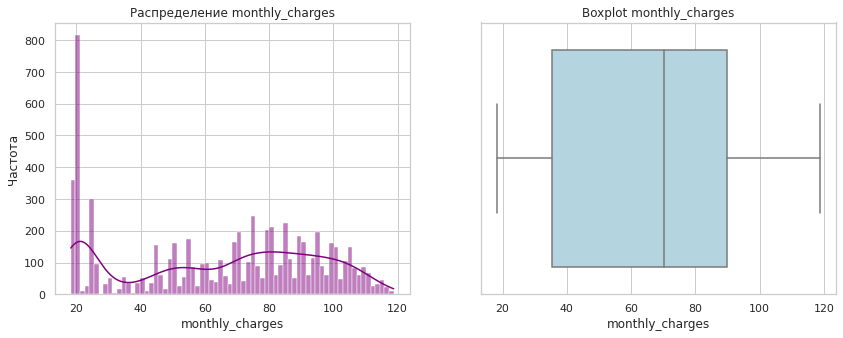

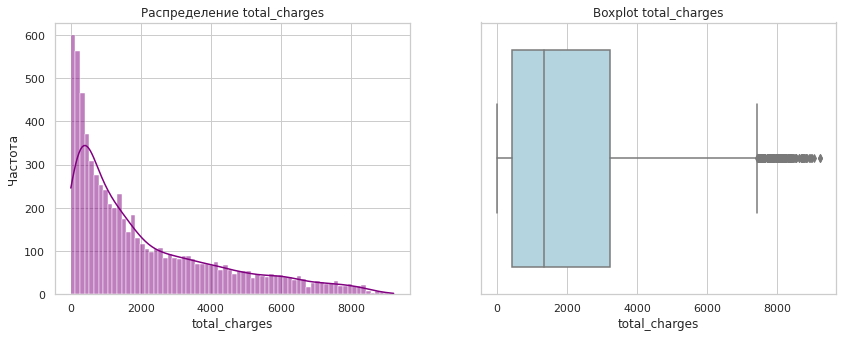

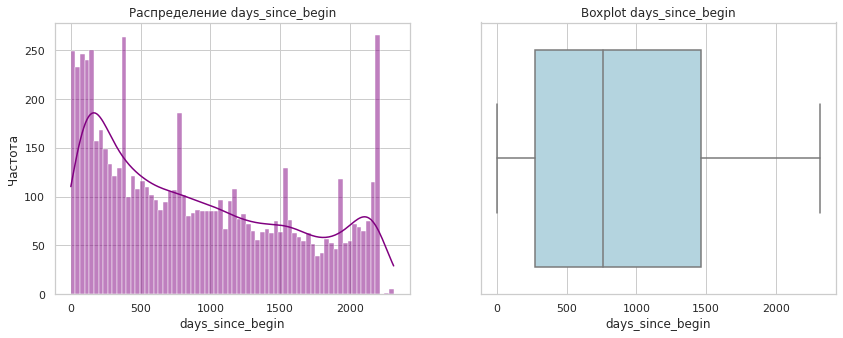

In [30]:
# гистограммы и boxplot для непрерывных признаков
for col in quant_columns:
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    sns.histplot(data[col], kde=True, bins=70, color='purple', ax=ax[0])
    ax[0].set_title(f'Распределение {col}')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('Частота')

    sns.boxplot(x=data[col], color='lightblue', ax=ax[1])
    ax[1].set_title(f'Boxplot {col}')
    
    plt.show()

monthly_charges: медианный платеж составляет 70, наблюдается левосторонняя асимметрия (больше клиентов с высокими платежами), при этом 25% клиентов платят ≤ 35.5, а 75% — ≤ 89.85.

total_charges: медианные общие траты составляют 1343, наблюдается правосторонняя асимметрия, достаточно много клиентов с высокими суммарными платежами.

days_since_begin: среднее время пребывания клиента составляет 898, но медиана (761 дня) меньше среднего, что указывает на правостороннюю асимметрию (длинный хвост в сторону больших значений). Высокий разброс по времени пребывания.

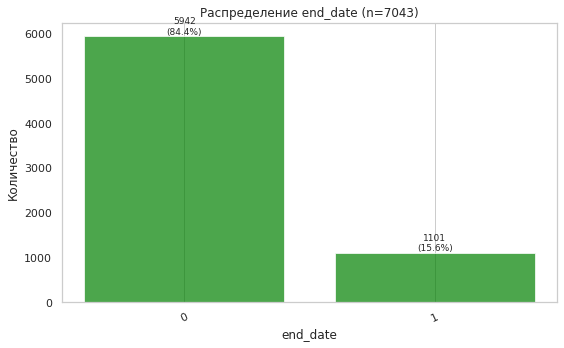

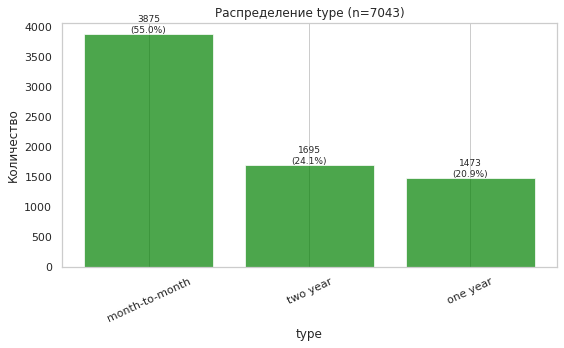

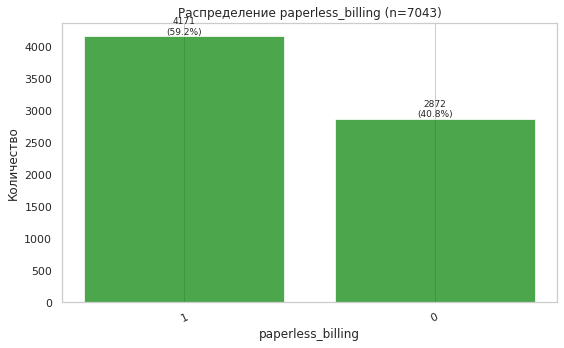

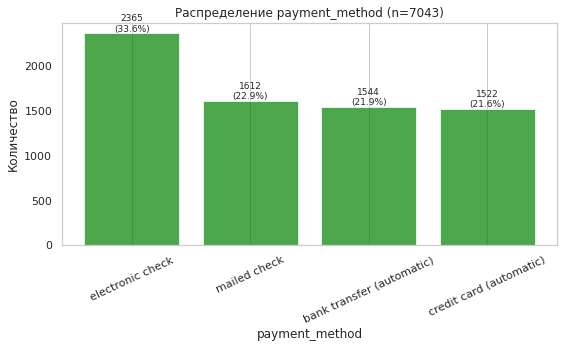

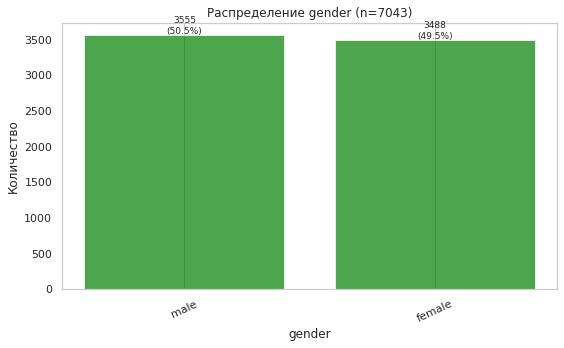

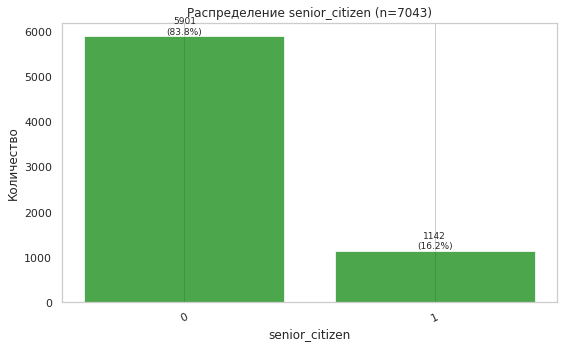

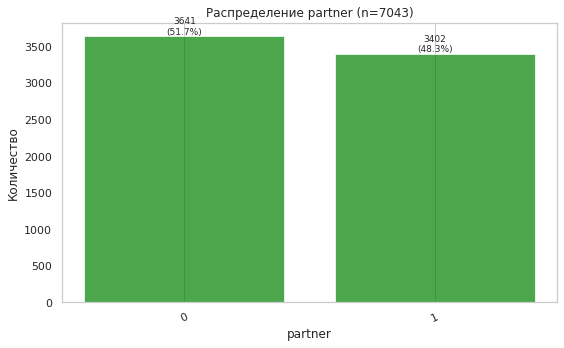

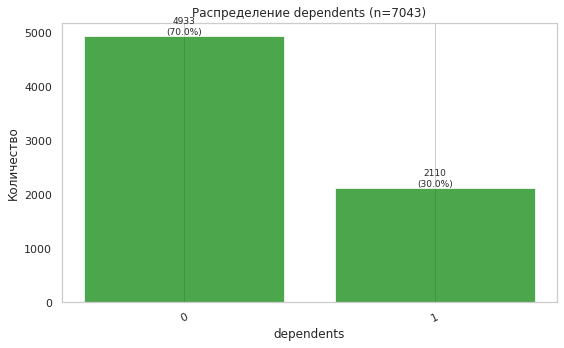

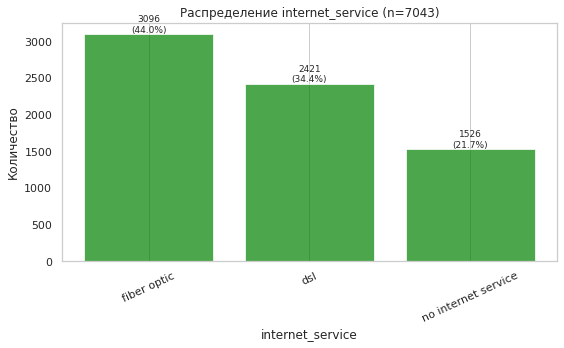

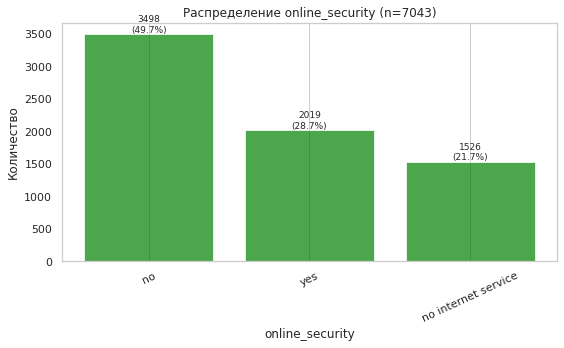

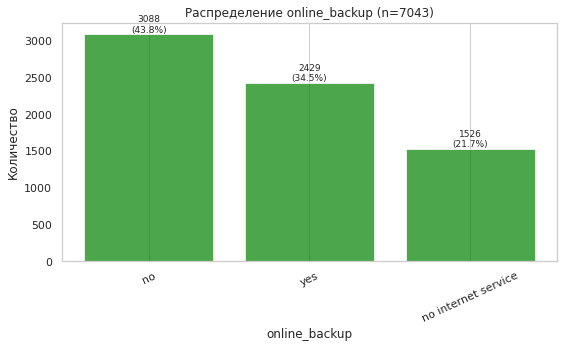

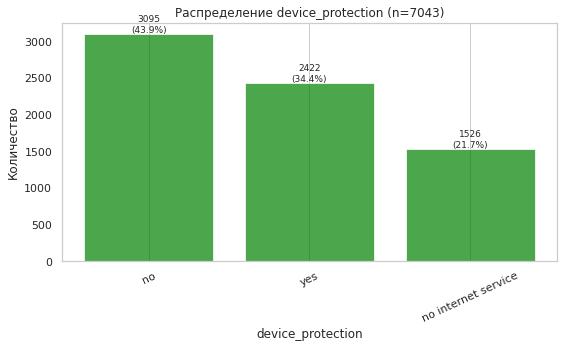

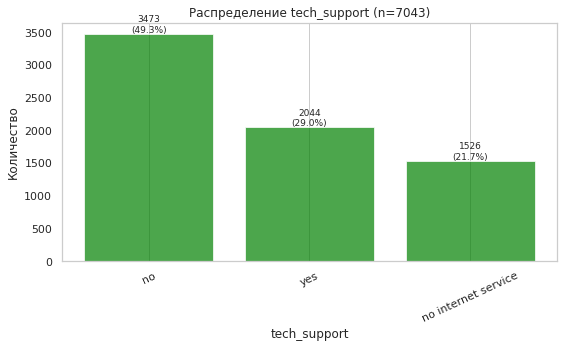

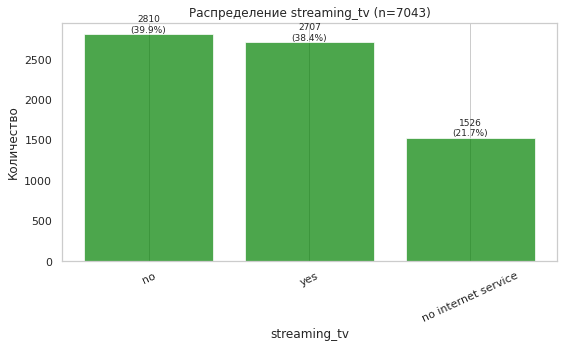

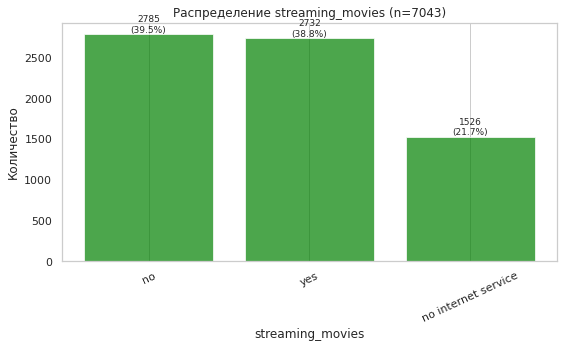

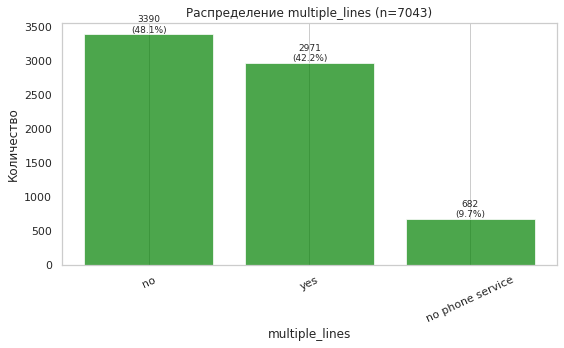

In [31]:
# столбчатые диаграммы для категориальных признаков
for col in cat_columns:
    plt.figure(figsize=(8, 5))
    
    # получаем значения и их частоты
    value_counts = data[col].value_counts()
    total = len(data[col])
    
    # создаем столбчатую диаграмму
    bars = plt.bar(value_counts.index.astype(str), value_counts.values, 
                   color='green', alpha=0.7)
    
    # подписи с абсолютными значениями и процентами
    for bar in bars:
        height = bar.get_height()
        percent = (height / total) * 100
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}\n({percent:.1f}%)',
                 ha='center', va='bottom', fontsize=9)
    
    plt.title(f'Распределение {col} (n={total})')
    plt.xlabel(col)
    plt.ylabel('Количество')
    plt.xticks(rotation=25)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

end_date: около 15.6% клиентов прекратили обслуживание.

Остальные признаки рассмотрим далее, где разделим клиентов по целевой переменной, то есть на тех, кто остался и ушел.

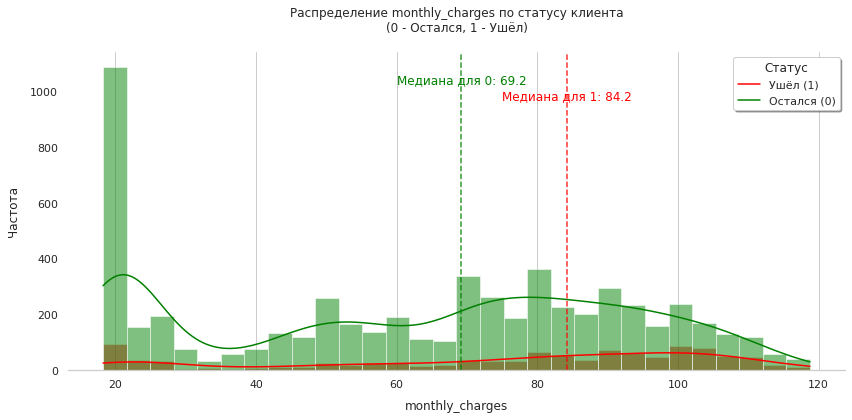

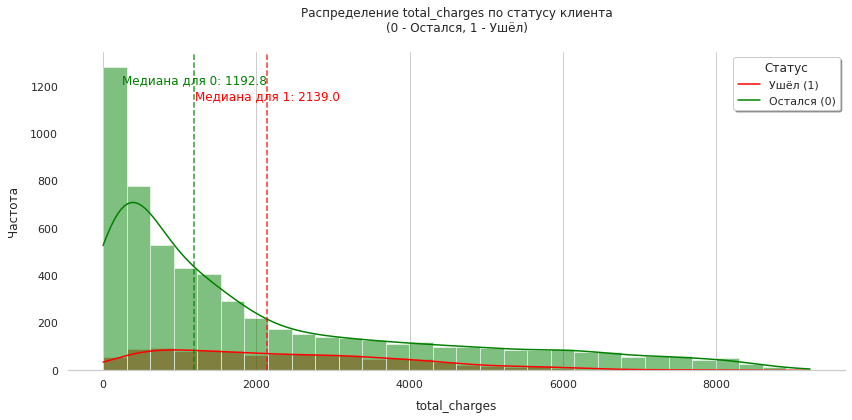

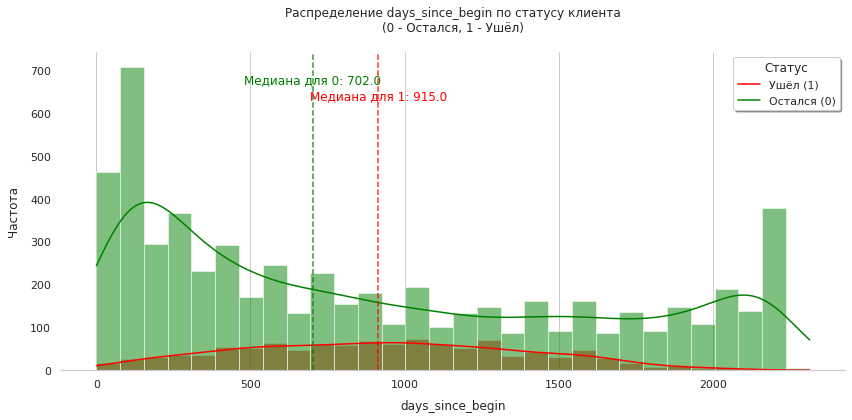

In [32]:
# распределение количесвтенных признаков по статусу клиента
for col in quant_columns:
    plt.figure(figsize=(12, 6))
    
    ax = sns.histplot(data=data, 
                     x=col, 
                     hue='end_date', 
                     kde=True, 
                     bins=30,
                     palette={0: "green", 1: "red"},
                     alpha=0.5,
                     edgecolor='white',
                     linewidth=0.5)
    
    # вертикальные линии для медиан
    median_0 = data[data['end_date'] == 0][col].median()
    median_1 = data[data['end_date'] == 1][col].median()
    
    plt.axvline(median_0, color='green', linestyle='--', linewidth=1.5, alpha=0.8)
    plt.axvline(median_1, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
    
    # аннотации для медиан
    plt.text(median_0, ax.get_ylim()[1]*0.9, 
             f'Медиана для 0: {median_0:.1f}', 
             color='green', ha='center')
    plt.text(median_1, ax.get_ylim()[1]*0.85, 
             f'Медиана для 1: {median_1:.1f}', 
             color='red', ha='center')
    
    plt.title(f'Распределение {col} по статусу клиента\n(0 - Остался, 1 - Ушёл)', pad=20)
    plt.xlabel(col, labelpad=10)
    plt.ylabel('Частота', labelpad=10)
    plt.legend(title='Статус', 
              labels=['Ушёл (1)', 'Остался (0)'], 
              frameon=True,
              shadow=True)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    sns.despine(left=True)
    
    plt.tight_layout()
    plt.show()

Клиенты, которые ушли, имели большую медианную месячную плату, общие расходы. Также в основном это клиенты, которые были с этой компанией довольно долго, несколько лет.

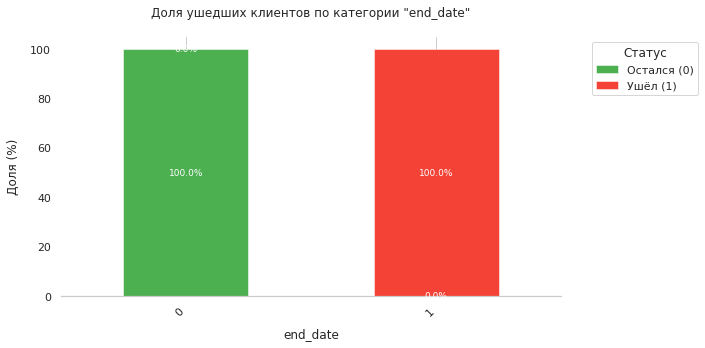

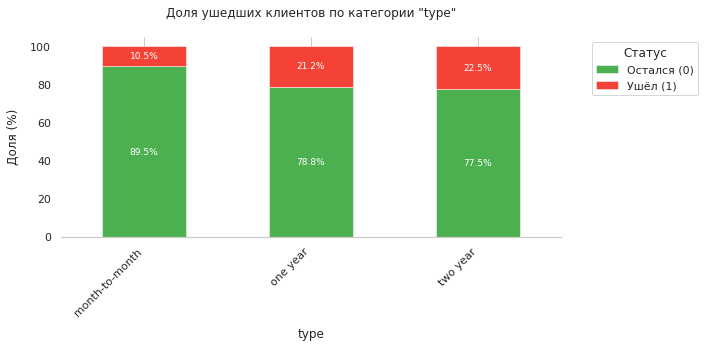

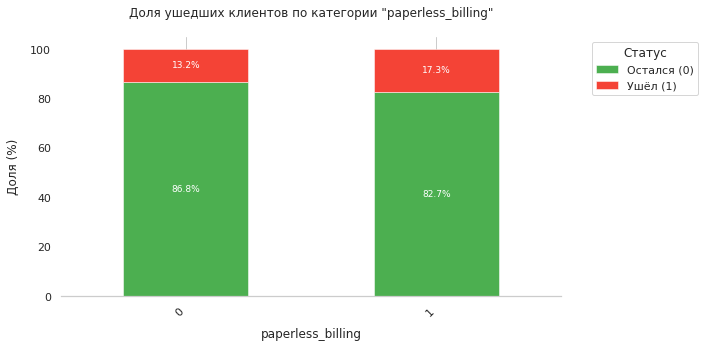

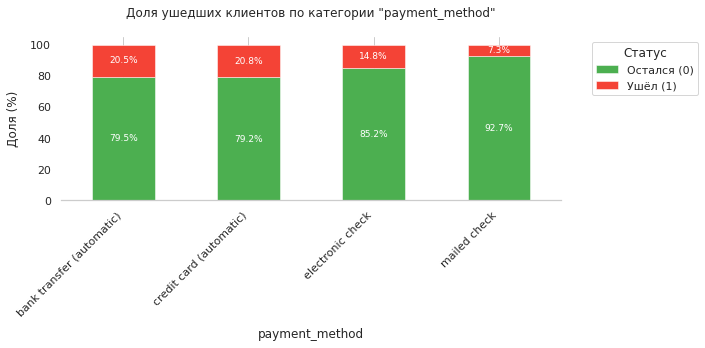

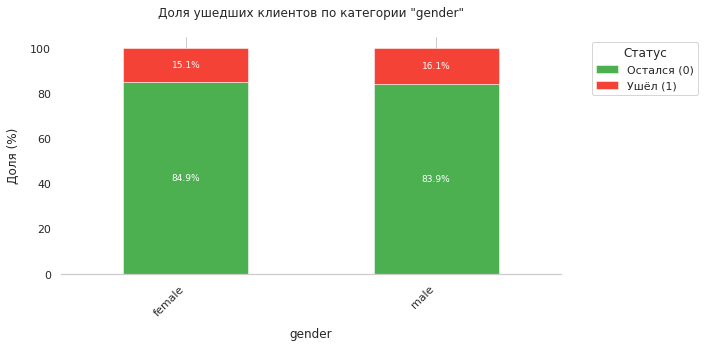

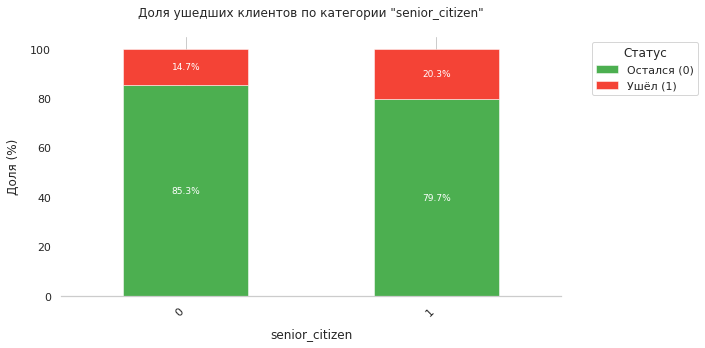

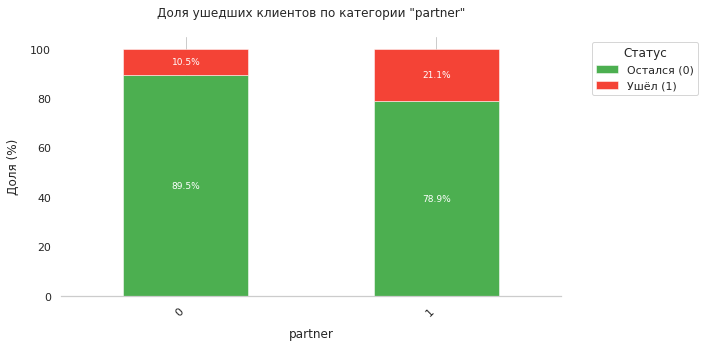

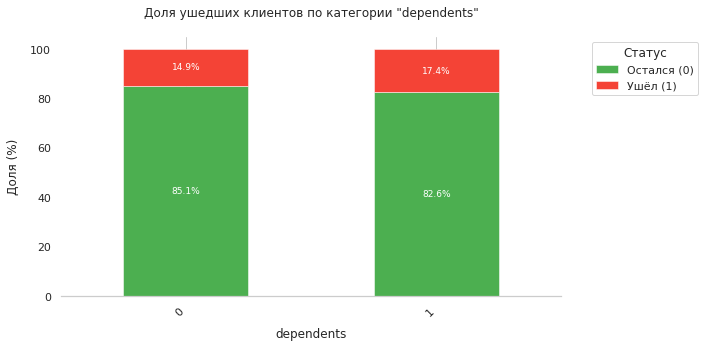

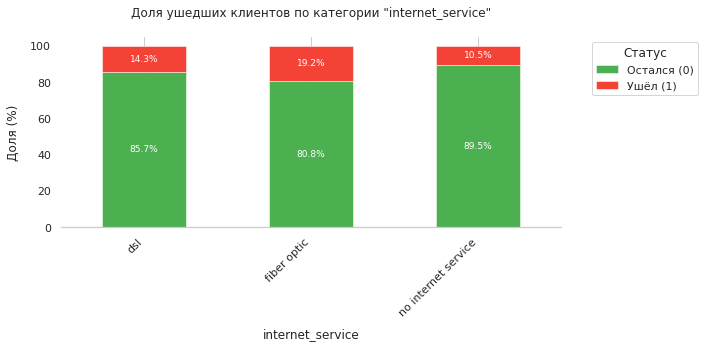

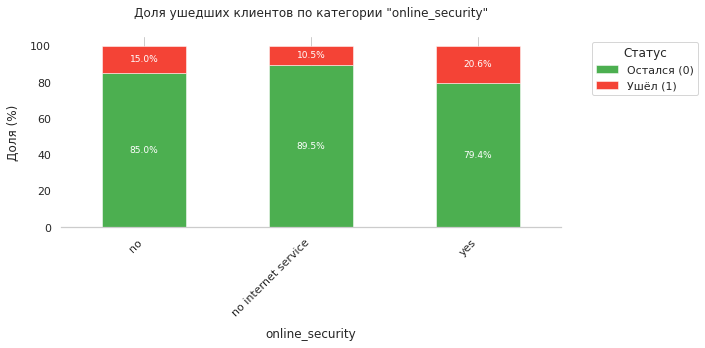

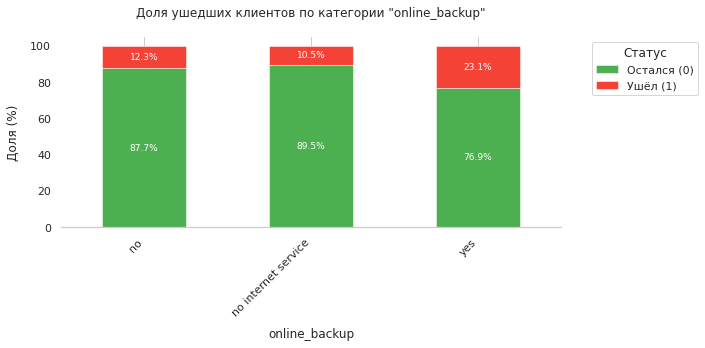

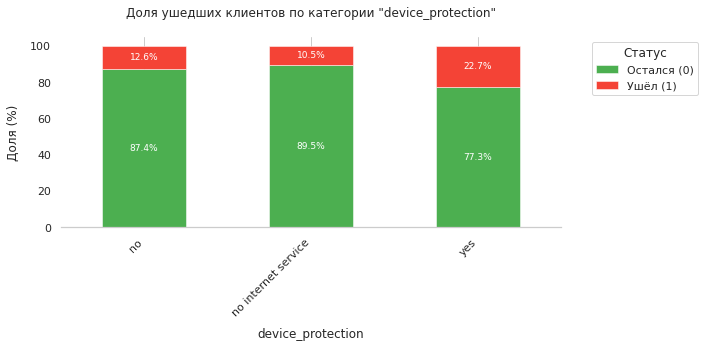

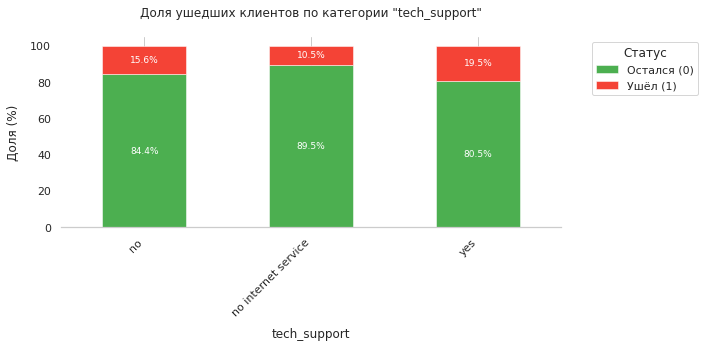

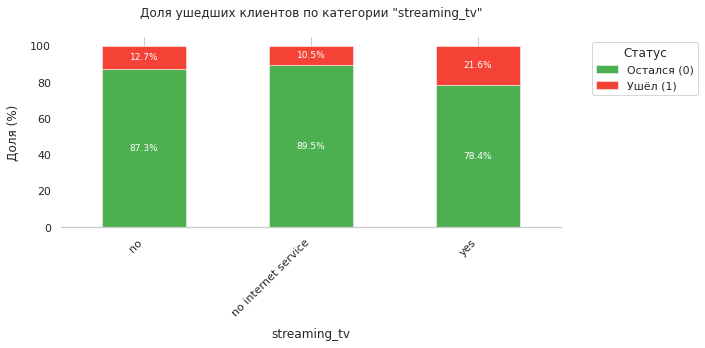

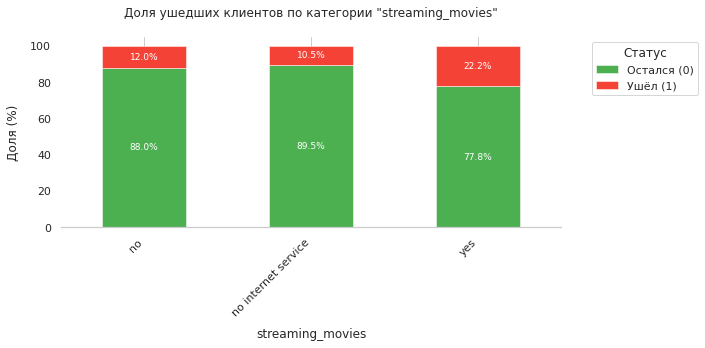

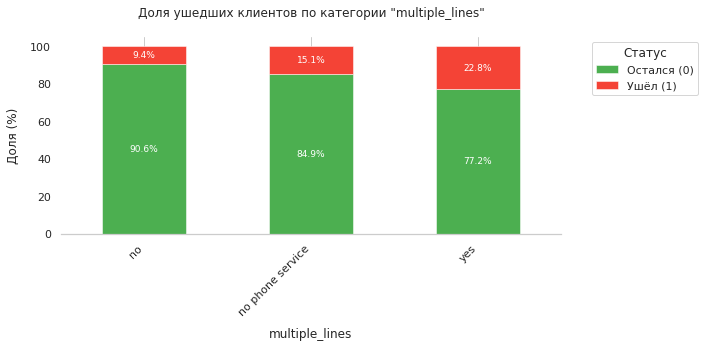

In [33]:
# распределение качественных признаков по статусу клиента
for col in cat_columns:
    # считаем доли и задаем порядок столбцов
    churn_counts = pd.crosstab(data[col], data['end_date'], normalize='index') * 100
    churn_counts.columns = ['Остался (0)', 'Ушёл (1)']
    
    ax = churn_counts.plot(
        kind='bar', 
        stacked=True, 
        figsize=(10, 5), 
        color=['#4CAF50', '#F44336'],
        edgecolor='white',
        linewidth=0.5
    )
    
    for i, (index, row) in enumerate(churn_counts.iterrows()):
        y0 = row['Остался (0)'] / 2
        ax.text(i, y0, f'{row["Остался (0)"]:.1f}%', 
                ha='center', va='center', color='white', fontsize=9)
        
        y1 = row['Остался (0)'] + row['Ушёл (1)'] / 2
        ax.text(i, y1, f'{row["Ушёл (1)"]:.1f}%', 
                ha='center', va='center', color='white', fontsize=9)
    
    plt.title(f'Доля ушедших клиентов по категории "{col}"', pad=20)
    plt.xlabel(col, labelpad=10)
    plt.ylabel('Доля (%)', labelpad=10)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Статус', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    sns.despine(left=True)
    plt.tight_layout()
    plt.show()

Тут отображены доли ушедших внутри каждой категории признака, а не абсолютное количество.

type: 1-я категория типа оплаты наиболее выгодна для удержания клиентов, наибольший отток в 3-й категории (22.5%), затем во 2-й (21.2%), наименьший — в 1-й (10.5%).

paperless_billing: с электронным расчетным листом чаще уходят.

payment_method: реже всего уходят с типом платежа mailed-check, автоматические типы хуже влияют.

gender: отток почти одинаковый.

senior_citizen: пенсионеры чаще уходят.

partner: клиенты с партнерами тоже чаще уходят.

dependents: также с детьми.

internet_service: те, у кого был интернет подключен через оптоволоконный кабель, уходят чаще.

online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies: для всех этих интернет-услуг картина примерно одинаковая: около 20% доля от тех, кто ими пользовался, уходят; около 13% уходят те, кто не подключал доп. услугу; 10% уходят те, кто вообще услугу интернета не подключал.

multiple_lines: 23% доли от тех, кто пользовался этой услугой, ушли, на втором месте клиенты, которые телефонными услугами вообще не пользуются, и на трепьем - кто конкретно эту услугу не подключал.

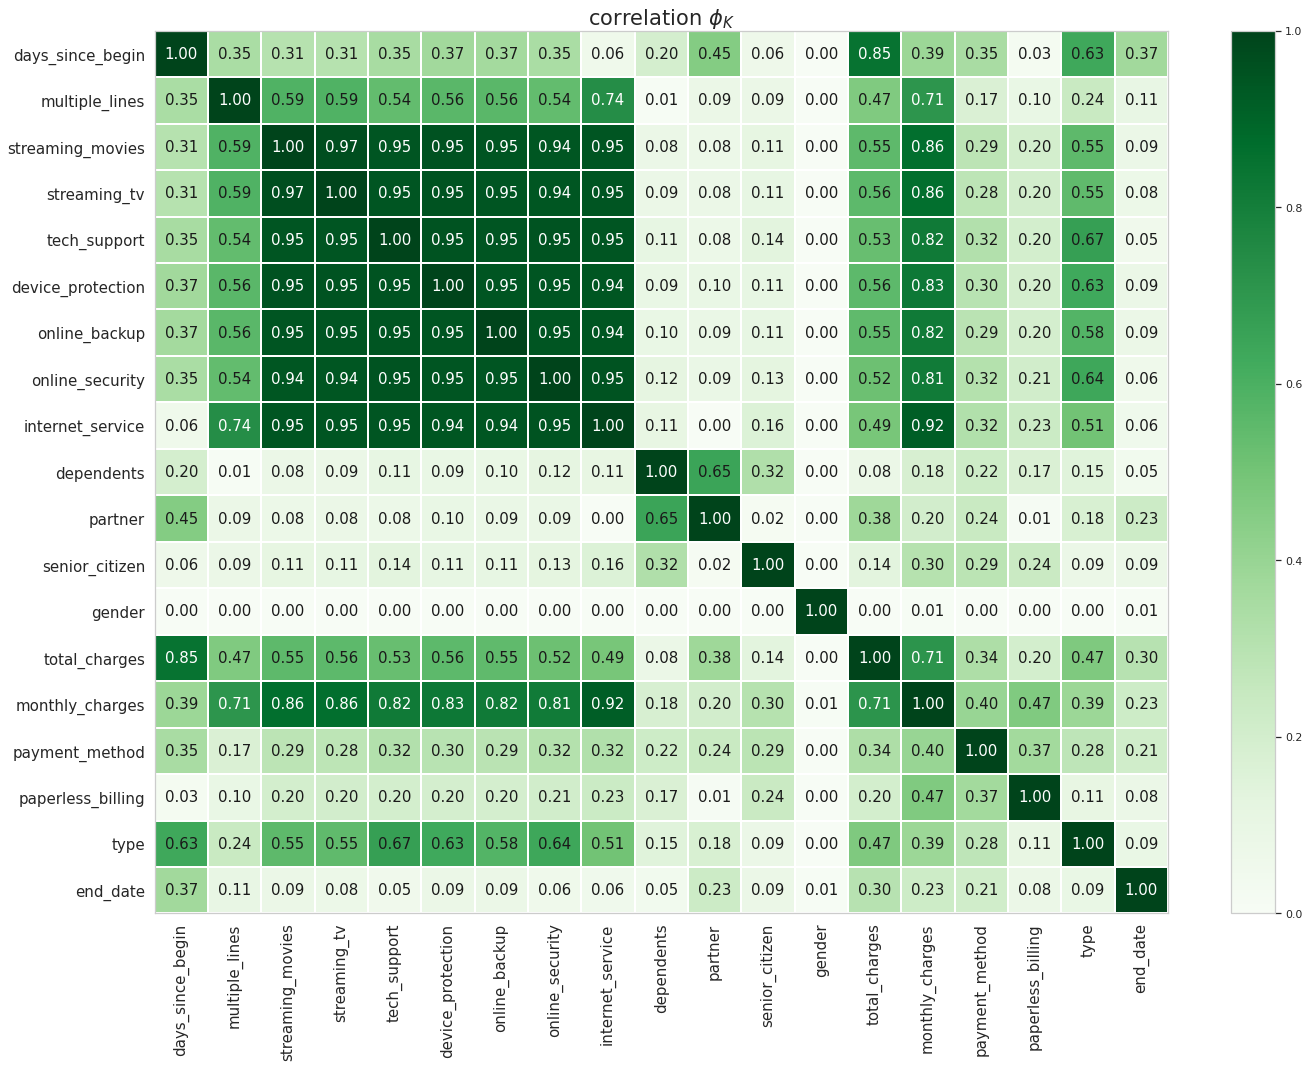

In [34]:
# рассчитаем матрицу корреляции Phik
phik_matrix = data.drop(columns=['customer_id'], errors='ignore').phik_matrix(interval_cols=quant_columns)

# визуализируем корреляционную матрицу
plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

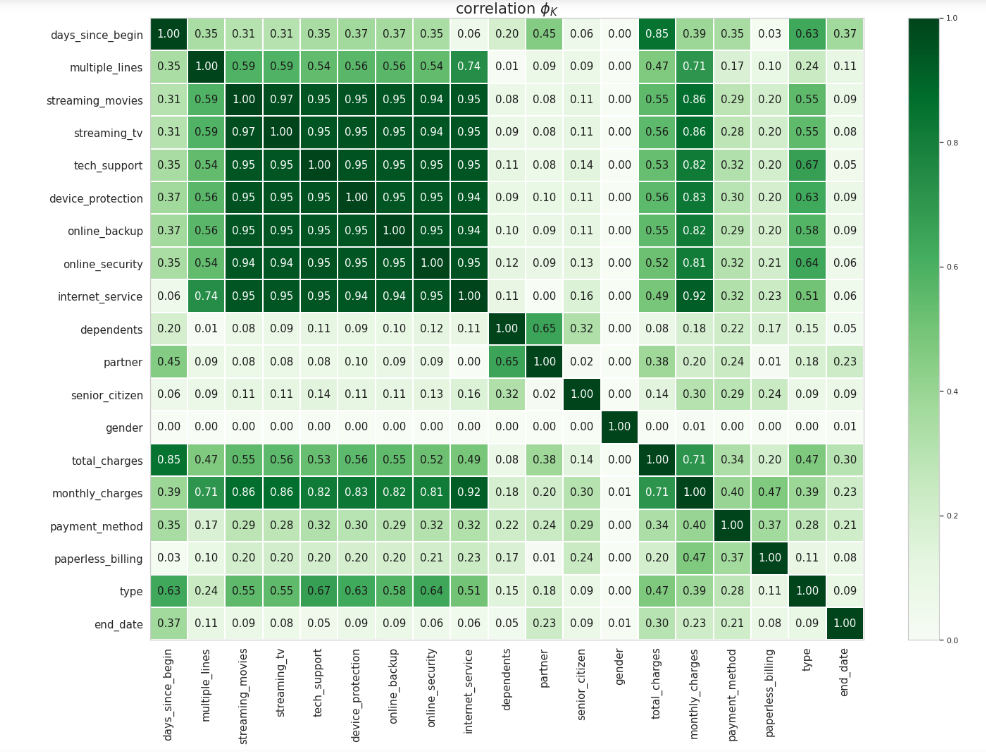

Удалим признаки streaming_movies, streaming_tv, tech_support, device_protection, online_backup, online_security, internet_service, dependents, senior_citizen, gender, paperless_billing, type, так как они слабо не коррелируют с целевым.

Наблюдается мультиколлинеарность между многими признаками, но они все будут удалены.

С целевым признаком end_date умеренно коррелируют days_since_begin (0.37), total_charges (0.3), слабо - partner (0.23), monthly_charges (0.23), payment_method (0.21).

In [35]:
data = data.drop(columns=['paperless_billing', 'gender','dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies'], errors='ignore')

In [36]:
# оставшиеся признаки
data.columns

Index(['customer_id', 'end_date', 'type', 'payment_method', 'monthly_charges',
       'total_charges', 'senior_citizen', 'partner', 'multiple_lines',
       'days_since_begin'],
      dtype='object')

*В данном пунке была выполнена предобработка и исследовательский анализ нового датафрейма, сненерирован новый признак, визуализированы распределения признаков, проведен корреялционный анализ.*

## Подготовка данных

In [37]:
# разделяем данные на выборки
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['customer_id', 'end_date'], axis=1),
    data['end_date'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify =  data['end_date']
)

print(f'Размерность тренировочных выборок: X - {X_train.shape}, y - {y_train.shape}')
print(f'Размерность тестовых выборок: X - {X_test.shape}, y - {y_test.shape}')

Размерность тренировочных выборок: X - (5282, 8), y - (5282,)
Размерность тестовых выборок: X - (1761, 8), y - (1761,)


In [38]:
# создаём списки с названиями признаков
ohe_columns = ['payment_method', 'multiple_lines', 'type']
num_columns = ['monthly_charges', 'total_charges', 'days_since_begin']

In [39]:
data.head()

,customer_id,end_date,type,payment_method,monthly_charges,total_charges,senior_citizen,partner,multiple_lines,days_since_begin
0,7590-VHVEG,0,month-to-month,electronic check,29.85,31.04,0,1,no phone service,31.0
1,5575-GNVDE,0,one year,mailed check,56.95,2071.84,0,0,no,1036.0
2,3668-QPYBK,0,month-to-month,mailed check,53.85,226.17,0,0,no,123.0
3,7795-CFOCW,0,one year,bank transfer (automatic),42.30,1960.60,0,0,no phone service,1371.0
4,9237-HQITU,0,month-to-month,electronic check,70.70,353.50,0,0,no,153.0


In [40]:
# препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ohe_columns)
    ],
    remainder='passthrough'
)

# пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# гиперпараметры для поиска
param_distributions = [
    {
        'classifier': [LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)],
        'classifier__C': uniform(0.01, 10)
    },
    {
        'classifier': [RandomForestClassifier(class_weight='balanced', random_state=42)],
        'classifier__n_estimators': randint(50, 200),
        'classifier__max_depth': [5, 10, 15, None],
        'classifier__min_samples_split': randint(2, 10)
    },
    {
        'classifier': [LGBMClassifier(class_weight='balanced', random_state=42)],
        'classifier__n_estimators': randint(100, 300),
        'classifier__max_depth': [3, 5, 7, 10, -1],
        'classifier__learning_rate': uniform(0.01, 0.2),
        'classifier__num_leaves': randint(20, 100)
    }
]

## Обучение моделей машинного обучения и выбор лучшей

In [41]:
# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# поиск лучшей модели
search.fit(X_train, y_train)

# лучшая модель и параметры
print("Лучшая модель:", search.best_estimator_.named_steps['classifier'])
print("Лучшие параметры:", search.best_params_)
print("ROC-AUC на кросс-валидации:", search.best_score_)

# оценка на тестовой выборке
y_pred_proba = search.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC на тестовой выборке:", roc_auc)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END classifier=LGBMClassifier(class_weight='balanced', random_state=42), classifier__learning_rate=0.1693085973720466, classifier__max_depth=7, classifier__n_estimators=171, classifier__num_leaves=80; total time= 6.3min
[CV] END classifier=LGBMClassifier(class_weight='balanced', random_state=42), classifier__learning_rate=0.1693085973720466, classifier__max_depth=7, classifier__n_estimators=171, classifier__num_leaves=80; total time= 4.8min
[CV] END classifier=LGBMClassifier(class_weight='balanced', random_state=42), classifier__learning_rate=0.1693085973720466, classifier__max_depth=7, classifier__n_estimators=171, classifier__num_leaves=80; total time= 2.4min
[CV] END classifier=LGBMClassifier(class_weight='balanced', random_state=42), classifier__learning_rate=0.1693085973720466, classifier__max_depth=7, classifier__n_estimators=171, classifier__num_leaves=80; total time=  42.4s
[CV] END classifier=LGBMClassifier(cla

Лучшая модель: LGBMClassifier(class_weight='balanced', learning_rate=0.14606150771755597,
               max_depth=3, n_estimators=266, num_leaves=37, random_state=42)

ROC-AUC на кросс-валидации: 0.8788085033282865

ROC-AUC на тестовой выборке: 0.9154594396182552

In [42]:
# преобразуем результаты в DataFrame
results_df = pd.DataFrame(search.cv_results_)

columns_to_show = [
    'params',
    'mean_test_score', 
    'std_test_score',
    'mean_fit_time', 
    'std_fit_time',
    'mean_score_time',
    'rank_test_score'
]

# сортируем по ROC-AUC
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

pd.set_option('display.float_format', '{:.3f}'.format)
results_df[columns_to_show].head(10)

,params,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,rank_test_score
11,{'classifier': LGBMClassifier(class_weight='ba...,0.879,0.014,0.751,0.080,0.046,1
16,{'classifier': LGBMClassifier(class_weight='ba...,0.876,0.010,1.194,0.167,0.064,2
0,{'classifier': LGBMClassifier(class_weight='ba...,0.870,0.008,171.660,143.167,0.068,3
9,{'classifier': LGBMClassifier(class_weight='ba...,0.869,0.010,1.961,0.168,0.096,4
15,{'classifier': LGBMClassifier(class_weight='ba...,0.863,0.012,1.687,0.063,0.030,5
8,{'classifier': LGBMClassifier(class_weight='ba...,0.851,0.014,5.481,1.067,0.082,6
2,{'classifier': LGBMClassifier(class_weight='ba...,0.831,0.011,2.409,0.330,0.031,7
3,{'classifier': LGBMClassifier(class_weight='ba...,0.823,0.015,1.414,0.148,0.100,8
17,{'classifier': RandomForestClassifier(class_we...,0.814,0.017,0.467,0.023,0.032,9
6,{'classifier': RandomForestClassifier(class_we...,0.811,0.017,0.478,0.082,0.030,10


Лучшая модель — LGBMClassifier с mean_test_score = 0.879 и минимальной дисперсией (std_test_score = 0.014). Она заняла 1 место среди всех протестированных конфигураций.

Разница в качестве между топ-5 моделей небольшая — от 0.879 до 0.863, что говорит о стабильности LGBM на текущих признаках.

Время обучения увеличивается при небольшом приросте качества, поэтому с точки зрения баланса лучше — модель на 1-м или 2-м месте.

Лучшая модель RandomForestClassifier показала mean_test_score = 0.814, что на 0.065 ниже, чем у топовой модели LGBM.

Однако время обучения у RandomForest — в 2 раза ниже (0.47–0.50 сек против 0.73+ сек у LGBM).

## Порог классификации и оценка важности признаков

In [43]:
# посмотрим на матрицу ошибок и другие метрики
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Матрица ошибок (confusion matrix):")
print(cm)

# precision, recall, f1, accuracy
print("\nОтчёт классификации:")
print(classification_report(y_test, y_pred, target_names=['Остался (0)', 'Ушёл (1)']))

Матрица ошибок (confusion matrix):
[[1269  217]
 [  51  224]]

Отчёт классификации:
              precision    recall  f1-score   support

 Остался (0)       0.96      0.85      0.90      1486
    Ушёл (1)       0.51      0.81      0.63       275

    accuracy                           0.85      1761
   macro avg       0.73      0.83      0.77      1761
weighted avg       0.89      0.85      0.86      1761



- 1269 — правильно предсказано: остался
- 224 — правильно предсказано: ушёл
- 217 — ошибка: модель предсказала "остался", но человек ушёл
- 51 — ошибка: модель предсказала "ушёл", но человек остался

Recall = 0.81 — из всех реально ушедших модель обнаружила 81%

Это хороший результат. Так как пропустить потенциально уходящих клиентов хуже и менее выгодно, чем ошибочно предположить уход.

*Построим ROC-кривую для нахождения оптимального порога на тестовой выборке.*

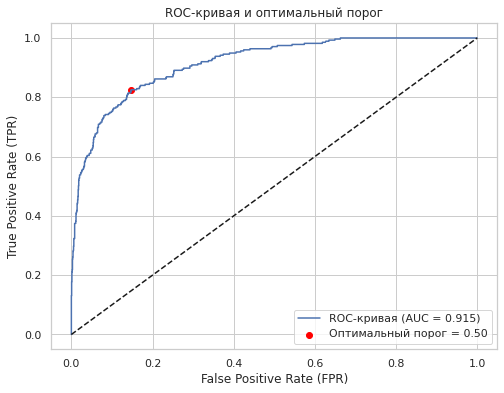

Оптимальный порог: 0.497


In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# оптимальный порог (максимум TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# визуализация
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], c='red', label=f'Оптимальный порог = {optimal_threshold:.2f}')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривая и оптимальный порог')
plt.legend()
plt.grid(True)
plt.show()

print(f"Оптимальный порог: {optimal_threshold:.3f}")

Оптимальный порог 0.947 почти не отличается от стандартного 0.5, поэтому можно не менять его.

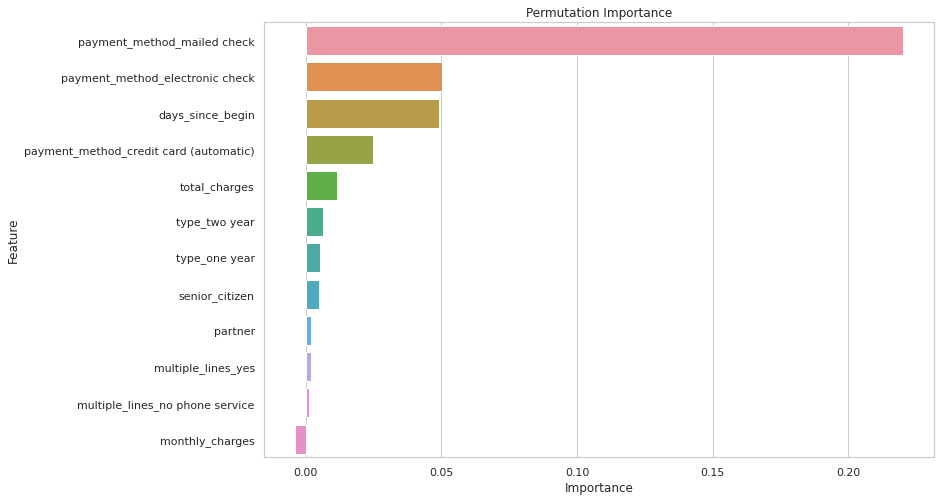

In [45]:
# выведем важность признаков
pipeline = search.best_estimator_
model = pipeline.named_steps['classifier']
preprocessor = pipeline.named_steps['preprocessor']
X_train_transformed = preprocessor.transform(X_train)

# получаем имена признаков
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(ohe_columns)
num_feature_names = num_columns
remainder_feature = ['partner', 'senior_citizen']
all_feature_names = np.concatenate([ohe_feature_names, num_feature_names, remainder_feature])


result = permutation_importance(
    model, 
    X_train_transformed, 
    y_train, 
    n_repeats=10,
    random_state=42
)

feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Permutation Importance')
plt.show()

Топ-3 самых важных признака:
- payment_method_mailed check (~0.26) — самый значимый
- payment_method_electronic check (~0.05)
- days_since_begin (~0.05)

Признак monthly_charges вообще как будто просто не нужен нашей модели при текущем наборе признаков, судя по графику.

100%|===================| 5270/5282 [00:13<00:00]        

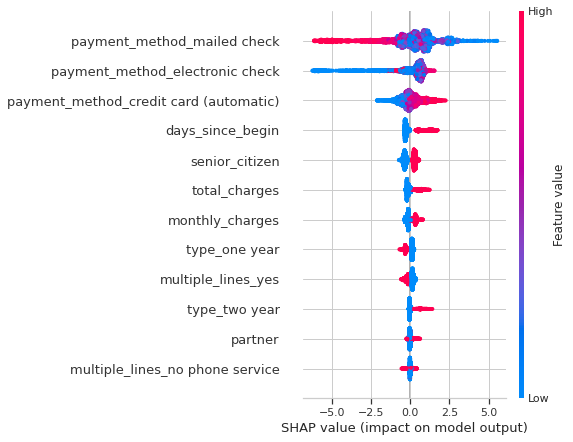

In [46]:
# проверим важность признаков через SHAP
explainer = shap.Explainer(model, X_train_transformed)

# вычисляем значения SHAP для обучающей выборки
shap_values = explainer(X_train_transformed)

ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(ohe_columns)
all_feature_names = np.concatenate([ohe_feature_names, num_columns, remainder_feature])

# обновим имена признаков у shap_values
shap_values.feature_names = all_feature_names.tolist()

# summary plot
shap.summary_plot(shap_values.values, X_train_transformed, feature_names=all_feature_names)

payment_method_mailed check - если клиент использует этот тип, он с большей вероятностью останется

payment_method_electronic check, credit card (automatic) - если эти типы, то с большей вероятностью уйдет

days_since_begin - чем дольше клиент с компанией, тем больше вероятность, что уйдет

senior_citizen - меньше влияет, но пенсионеры чаще уходят

total_charges - чем больше, тем чаще уходят, но это связано и с большим количеством дней, проведенных с компанией

monthly_charges - те, у кого траты выше, более склонны к уходу.

## Общий вывод и рекомендации заказчику

**Выводы по проекту:**
- были загружены и изучены данные
- проведен предварительный исследовательский анализ и предобработка для каждой таблицы:
    - выполнено преобразование названий столбцов
    - изменены некоторые типы данных
    - проверены пропуски
    - проверены явные и неявные дубликаты
- таблицы объединены в один датафрейм
- выполнен сследовательский анализ и предобработка данных объединённого датафрейма:
    - сгенерирован новый признак
    - визуализированы распределения признаков
    - проведен корреялционный анализ
- выполнена подготовка данных для обучения модели:
    - данные разделены на две выборки
    - создан препроцессор, с помощью которого данные масштабируются и кодируются
- обучено три модели машинного обучения и выбрана лучшая модель:
    - лучшая модель - LGBMClassifier(class_weight='balanced', learning_rate=0.14606150771755597, max_depth=3, n_estimators=266, num_leaves=37, random_state=42)
    - результат метрики ROC-AUC на тестовой выборке: 0.915
- выполнена оценка важности признаков (payment_method_mailed check, payment_method_electronic check, days_since_begin - самые значимые)
- далее сделаны рекомендации заказчику

**Рекомендации заказчику:**
- *причины оттока клиентов:*
    - клиенты с ежемесячной оплатой значительно реже уходят (лишь 10.5%), чем те, кто заключил долгосрочный контракт
    - электронные чеки коррелируют с более высоким оттоком, возможны проблемы с осведомлённостью или прозрачностью
    - удержание выше у клиентов, платящих через бумажный чек
    - отток выше у пользователей с оптоволоконным интернетом, возможны проблемы с качеством или завышенными ожиданиями
    - клиенты, не подключившие доп.услуги (безопасность, резервное копирование, техподдержка и др.), уходят реже.
    - пенсионеры, клиенты с партнёрами и детьми уходят чаще, вероятно, эти категории чувствительны к цене и стабильности сервиса
    - уходящие клиенты платят больше в среднем в месяц и в сумме.
- *используйте построенную модель для раннего выявления клиентов с высокой вероятностью оттока и предлагайте им:*
    - персонализированные предложения (например, скидки, улучшенные условия)
    - улучшенный тарифный пакет (возможно, с включённой техподдержкой или антивирусом
    - улучшение поддержки и сервиса: особенно для клиентов с высоким ARPU (доход на пользователя), которые наиболее ценны и одновременно склонны к оттоку                               
- *возможности для дальнейшего развития:*
    - внедрение системы скоринга оттока на уровне CRM
    - проведение A/B тестов различных стратегий удержания
    - использование модели для определения оптимального момента предложения бонусов или промокодов
    - расширение данных: добавление логов обращений в техподдержку, отзывов, скорости интернета и т.д.